In [1]:
#++++++++++++++++++++++++++++++++++++++++++++++
# Before running the script, edit 
# 'SET HYPERPARAMETERS' 
# - the rest is automated
#++++++++++++++++++++++++++++++++++++++++++++++

##################
### IMPORT MODULES
##################

### System
import sys
import os
from fnmatch import fnmatch 

### I/O
import json
import pickle

### General Processing
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import math
import collections
from collections import OrderedDict
from collections import namedtuple
DottedDict = namedtuple

## DECOMPOSITION
from sklearn.decomposition import NMF
from scipy.linalg import svd
from sklearn.model_selection import train_test_split

### NLU
from ibm_watson import NaturalLanguageUnderstandingV1 as NaLaUn
from ibm_watson.natural_language_understanding_v1 import Features, CategoriesOptions,ConceptsOptions,EntitiesOptions,KeywordsOptions,RelationsOptions,SyntaxOptions

### Presentation / apps
from matplotlib import pyplot as plt
import seaborn as sns

import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
import dash_table.FormatTemplate as FormatTemplate
from dash_table.Format import Sign
from dash.dependencies import Input, Output

import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

## GENERAL FUNCTIONS 

### SELECTION
def random_split(lst,split=0.5):
    shuffled = np.array(lst)
    np.random.shuffle(shuffled)
    split    = int(split * len(shuffled))
    return  shuffled[-split:] , shuffled[:-split]

### NORMALIZATION
#### Statistic normalization - subtract mean, scale by standard deviation
def norm_stat(vec, weights = False):
    '''
    Normalizes a vector v-v.mean())/v.std() 
    '''
    if weights:
        return  np.mean(abs(vec - vec.mean()))  
    return (vec-vec.mean())/vec.std()

#### Algebraic normalization - dot product
def norm_dot(vec, weights = False):
    '''
    Normalizes a vector - dot product: v @ v = 1
    '''
    if weights:
        return  np.sqrt(vec @ vec)
    
    return vec / np.sqrt(vec @ vec)

#### Algebraic normalization - dot product
def norm_sum(vec, weights = False):
    '''
    Normalizes a vector - sum: v.sum = 1
    '''
    if weights:
        return  vec.sum()
    
    return vec / vec.sum()

#### Scaled Normalization -
def scale(vec, weights = False):
    '''
    Normalizes a vector: v.min = 0, v.max = 1
    '''
    stop_divide_by_zero = 0.00000001
    if weights:
        return (vec.max()-vec.min() + stop_divide_by_zero)
    return (vec-vec.min())/(vec.max()-vec.min() + stop_divide_by_zero)
def cleanup_chars(string,char_list = ('\n',' ')):
    result = string
    for char in char_list:
        result = result.replace(char,'')
    return result

### OS system commands

from fnmatch import fnmatch 
def ls(search,name_only = False):
    '''
    emulates unix ls (without flags). Accepts wildcard/'*' in 
    '''
    search_split = search.replace('/','/ ').split()
    pattern      =         search_split[ -1]
    path         = ''.join(search_split[:-1])
    all_names    = np.array(os.listdir(path)) # numpy array enables Boolean Mask
    if not name_only: # add path to each name
        all_names    = np.array([path+name for name in all_names]) 
    mask         = [fnmatch(name,pattern) for name in all_names]
    result       = all_names[mask]
    return result

##########################################
### IBM-WATSON/NLU API-KEY (DON'T EDIT)
##########################################
# The script asks for the API key when run. 
# Do NOT save API-Keys in the code. 

local_dir_exists = os.path.exists('.local')
if not local_dir_exists:
    os.mkdir('.local')
    
credentials_exists = os.path.exists('.local/crd.env')
if not credentials_exists:
    print('Credentials needed for https://cloud.ibm.com/catalog/services/natural-language-understanding )')
    apikey = input(prompt='API-Key?')
    apiurl = input(prompt='API-URL?')
    crd = open('.local/crd.env','w')
    crd.write(  'NATURAL_LANGUAGE_UNDERSTANDING_IAM_APIKEY='+apikey)
    crd.write('\nNATURAL_LANGUAGE_UNDERSTANDING_URL='       +apiurl)  
    

# dian_pkl_file = PATH['results']+'all_dictations_nlu.pkl'  
# dian_pkl_exists = os.path.exists(dian_pkl_file)
# if 'apikey' not in locals():
#     apikey = input(prompt='API-Key? ( https://cloud.ibm.com/catalog/services/natural-language-understanding )')  


# # MATRIX-FACTORIZATION: DIMENSIONALITY REDUCTION & ARCHETYPING

# ## CLUSTER FEATURES INTO OCCUPATION CATEGORIES
# ## Use non-zero matrix factorization for clustering
# ## Use singular value decomposition first state for determining overall similarity

class Archetypes:
    '''
    Archetypes: Performs NMF of order n on X and stores the result as attributes. 
    Archetypes are normalized: cosine similarity a(i) @ a(i) = 1. 
    Atributes:
        my_archetypes.n         - order / number of archetypes
        my_archetypes.X         - input matrix
        
        my_archetypes.model     - NMF model 
        my_archetypes.w         - NMF w-matrix 
        my_archetypes.h         - NMF h-matrix
        
        my_archetypes.o         - objects x archetypes matrix (from w-matrix)       
        my_archetypes.f         - features x archetypes matrix (from h-matrix)
        
    '''
    
    def __init__(self,X,n,norm = norm_dot,bootstrap = False, bootstrap_frac = 0.5):
        self.n = n
        self.X = X
        self.norm = norm
        
        if bootstrap:
            self.bootstrap_n    = bootstrap
            self.bootstrap_frac = bootstrap_frac
        else:
            self.bootstrap_n    = 1
            self.bootstrap_frac = 1
        
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w_dic = {}
        self.o_dic = {}
        self.h_dic = {}
        self.f_dic = {}   
        
        for j in range(self.bootstrap_n): 
            XX = self.X.sample(int(len(self.X) *self.bootstrap_frac))
            self.w_dic[j] = self.model.fit_transform(XX)
            self.o_dic[j] = pd.DataFrame(self.w_dic[j],index=XX.index)
            self.h_dic[j] = self.model.components_
            self.f_dic[j] = pd.DataFrame(self.h_dic[j],columns=XX.columns)
        
        self.w = self.w_dic[0]  # TEMPORARY
        self.o = self.o_dic[0]  # TEMPORARY
        self.h = self.h_dic[0]  # TEMPORARY
        self.f = self.f_dic[0]  # TEMPORARY


class Svd:
    ''''
    Singular value decomposition-as-an-object
        my_svd = Svd(X) returns
        my_svd.u/.s/.vt – U S and VT from the Singular Value Decomposition (see manual)
        my_svd.f        – Pandas.DataFrame: f=original features x svd_features
        my_svd.o        - Pandas.DataFrame: o=occupations x svd_features
        my_svd.volume(keep_volume) 
                        - collections.namedtuple ('dotted dicionary'): 
                          Dimensionality reduction. keeps 'keep_volume' of total variance
                          
                          
    '''
    def __init__(self,X):
        self.u,self.s,self.vt = svd(np.array(X))
        self.f = pd.DataFrame(self.vt,columns=X.columns)
        self.o = pd.DataFrame(self.u,columns=X.index)
        
    def volume(self,keep_volume):
        ''' 
        Dimensionality reduction, keeps 'keep_volume' proportion of original variance
        Type: collections.namedtuple ('dotted dictionary')
        Examples of usage:
        my_svd.volume(0.9).s - np.array: eigenvalues for 90% variance 
        my_svd.volume(0.8).f - dataframe: features for 80% variance
        my_svd.volume(0.5).o - dataframe: occupations for 50% variance      
        '''
        dotted_dic = collections.namedtuple('dotted_dic', 's f o')
        a1 = self.s.cumsum()
        a2 = a1/a1[-1]
        n_max = np.argmin(np.square(a2 - keep_volume))
        cut_dic = dotted_dic(s= self.s[:n_max],f= self.f.iloc[:n_max], o= self.o.iloc[:n_max])
        return cut_dic
        

##########################
## SET HYPERPARAMATERS
#### edit below ##########

# Import credentials
cred = open('.local/crd.env','r').read()
apikey,apiurl = cred.replace('NATURAL_LANGUAGE_UNDERSTANDING_IAM_APIKEY=','').replace(
                            'NATURAL_LANGUAGE_UNDERSTANDING_URL=','').split()

PATH = {}
PATH['data']    = '../data/Documents/'
PATH['results'] = './Watson-nlu-results/'

NLU = {}
NLU['apikey']         = apikey
NLU['apiurl']         = apiurl
NLU['version']        = '2019-07-12'
NLU['features']       = Features(
                        categories= CategoriesOptions(),
                        concepts  = ConceptsOptions(),
                        entities  = EntitiesOptions(),
                        keywords  = KeywordsOptions(),
                        relations = RelationsOptions(),
                        syntax    = SyntaxOptions()
                        )


class WatsonDocumentArchetypes:
    '''
    WatsonDocumentArchetypes performs Archetypal Analysis on a corpus consisting of a set of documents, for example a set 
    of articles, books, news stories or medical dictations.
    
    Input parameters:
    
    PATH            - Dictionary with paths to I/O
    PATH['data']    - Directory for input text files. Example: './data/input_texts/'
    PATH['results'] - Directory for output.           Example: './data/output_nlu/'
    
    NLU                   - Dictionary with information for running Watson NLU
    NLU['apikey']         - apikey for running Watson NLU
    NLU['apiurl']         - URL for Watson NLU API
    NLU['version']        - Watson NLU version, e.g. '2019-07-12'
    NLU['features']       - Features requested from Watson NLU for each document in the set, e.g. 
                                Features(
                                categories= CategoriesOptions(),
                                concepts  = ConceptsOptions(),
                                entities  = EntitiesOptions(),
                                keywords  = KeywordsOptions(),
                                relations = RelationsOptions(),
                                syntax    = SyntaxOptions()
                                )

    Attributes:

        
        self.PATH 
    
        
    '''
    from ibm_watson import NaturalLanguageUnderstandingV1 as NaLaUn
    from ibm_watson.natural_language_understanding_v1 import Features, CategoriesOptions,ConceptsOptions,EntitiesOptions,KeywordsOptions,RelationsOptions,SyntaxOptions
    
    def __init__(self, PATH, NLU, 
                 train_test = False):
        
        self.PATH       = PATH
        self.NLU        = NLU
        # To random partition documents into train/test-sets, 
        # choose relative size of test-set, train_test (1 = 100%)
        self.train_test = train_test  
        
        self.nlu_model  = NaLaUn(version=NLU['version'] , iam_apikey = NLU['apikey'], url = NLU['apiurl'])  #Local Natural Language Understanding object
            # Initiate X_matrix dictionaries
        self.X_matrix_dic = {}
        self.X_matrix_train_dic = {}
        self.X_matrix_test_dic  = {}
        self.archetypes_dic = {} 
 
        ################
        ## PREPARE DATA 
        ################
        self.filenames = ls(self.PATH['data']+'*.txt', name_only=True)  # all filenames ending with '.txt' 
        self.names     = [name.replace('.txt','') for name in self.filenames]
        self.all_names = self.names *1      # if train_test - self.names will be set to self.names_train
        self.dictation_dic = {}             # dictionary for dictation files
        for name in self.filenames:
            self.dictation_dic[name.replace('.txt','')] = open(self.PATH['data']+name, encoding="utf-8").read()
        self.dictation_df = pd.Series(self.dictation_dic)
            
        ####################
        ## TRAIN-TEST SPLIT 
        ####################
        if self.train_test: # 0<train_test<1 - the proportion of names to save as 'test (rounded downwards)
            self.names_test , self.names_train = random_split(self.all_names , self.train_test)
            self.names = self.names_train

        ###############################
        ## PERFORM WATSON NLU ANALYSIS
        ###############################
        
# QQQQQQQQQQQQQQQQQQ TODO QQQQQQQQQQQQQQQQQQ
#   * IF DICTATION ALREADY HAS PKL WITH Watson NLU: READ EXISTING PKL. SKIP NEW WATSON CALC.
#
 
        self.watson = {}    #Dictionary with Watson-NLU results for each dictation
        
        self.watson_pkl = PATH['results']+'all_dictations_nlu.pkl'  
        pkl_exists = os.path.exists(self.watson_pkl)

        if pkl_exists:
            self.watson = pickle.load( open( self.watson_pkl, "rb" ) )

        else: #perform nlu-analysis on dictations
            for item in list(self.dictation_dic.items()):
                lbl  = item[0]
                text = item[1]
                self.watson[lbl] = self.nlu_model.analyze(text = text, features=NLU['features'])
                f = open(PATH['results']+str(lbl)+'_nlu.pkl','wb')
                pickle.dump(self.watson[lbl],f)
                f.close()

            f = open(self.watson_pkl,'wb')
            pickle.dump(self.watson,f)
            f.close() 

        # Copy Watson NLU results to Pandas Dataframes
        self.watson_nlu = {}
        for dctn in self.watson.items():
            self.watson_nlu[dctn[0]] = {}
            for item in list(dctn[1].result.items()):
                self.watson_nlu[dctn[0]][item[0]]=pd.DataFrame(list(item[1]))


    ##############
    # ARCHETYPAL ANALYSIS
    ##############

    # CONSTRUCT X- MATRIX
    def X_matrix(self,typ = 'entities'):
        '''
        Construct the archetypal analysis X-matrix by pivoting the dataframe in the 
        dictionary my_wda.watson_nlu that contains the Watson NLU analysis in question
        
        X_matrix(typ)
            rows   : Dictations 
            columns: Variables; keywords/entities/concepts, from Watson NLU analysis
            values : Weights, from Watson NLU analysis
        
        the constructed X_matrix(typ) is saved as X_matrix_dic[typ]
        
        if my_wda.train_test has a value (not False) X_matrix_train_dic[typ] and X_matrix_test[typ]
        are added computed and added to their respective dicionaries
        '''
        if typ not in self.X_matrix_dic.keys():
            df = pd.DataFrame()
            for key in self.names:
                dfx = self.watson_nlu[key][typ].copy()
                dfx['dictation'] = key
                df = df.append(dfx,sort=True)
            if typ is 'entities':
                df = df[df['type']=='HealthCondition']
                df.rename({'relevance': 'rel0'}, axis=1,inplace=True)
                df['relevance'] = df['rel0'] * df['confidence']
            self.X_matrix_dic[typ] = df.pivot_table(index='dictation',columns='text',values='relevance').fillna(0)
        
        if self.train_test:
            self.X_matrix_train_dic[typ] = self.X_matrix_dic[typ]
            
            df = pd.DataFrame()
            for key in self.names_test:
                dfx = self.watson_nlu[key][typ].copy()
                dfx['dictation'] = key
                df = df.append(dfx,sort=True)
            if typ is 'entities':
                df = df[df['type']=='HealthCondition']
                df.rename({'relevance': 'rel0'}, axis=1,inplace=True)
                df['relevance'] = df['rel0'] * df['confidence']
            self.X_matrix_test_dic[typ] = df.pivot_table(index='dictation',columns='text',values='relevance').fillna(0)
        return self.X_matrix_dic[typ]

    # CALCULATE ARCHETYPES
    def archetypes(self,typ='entities',n_archs=6,bootstrap = False, bootstrap_frac = 0.5):
        if typ not in self.archetypes_dic.keys():
            self.archetypes_dic[typ] = {}
        hyperparam = (n_archs,bootstrap,bootstrap_frac)
        self.X_matrix(typ)
        self.archetypes_dic[typ][hyperparam] = Archetypes(self.X_matrix(typ),n_archs,bootstrap = bootstrap, bootstrap_frac = bootstrap_frac)
        return self.archetypes_dic[typ][hyperparam]


    def display_archetype(self,arch_nr = -1, typ = 'entities' , n_archs = 6, var = 'variables', threshold = 0.10, norm = scale):
        fun = {'variables' : 'self.archetypes(typ = typ,n_archs = n_archs).f.T ',
               'dictations': 'self.archetypes(typ = typ,n_archs = n_archs).o'
               }
        f  = eval(fun[var])
        fn = f.apply(norm)
        if arch_nr == -1:
            return sns.clustermap(f).data2d
        else:
            arc        = fn.sort_values(by=arch_nr,ascending = False)
            if norm is norm_sum :  # normalized over sum: threshold is ignored volume
                arc_cs     = arc[arch_nr].cumsum() 
                thresh_idx = abs(arc_cs -(1- threshold)).values.argmin()
                result     = arc.iloc[:thresh_idx]
            if norm is scale :
                result = arc[
                            arc[arch_nr] >= (threshold * arc[arch_nr][0])                  ]
        return result

    
    
  

#%%

## DASH/PLOTLY  WEB APP
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
application = app.server
app.title = 'IBM Watson – Natural Language Understanding'

app.layout = html.Div(
    html.Div([
        html.Div([
            html.H1(children='DICTATION-NLU',
                    className = "nine columns",
                    style={
                    'margin-top': 20,
                    'margin-right': 20
                    },
            ),
            
            dcc.Markdown(children='''
                        Archetypal Analysis of Medical Dictations. Process:
                        1. **Natural Language Understanding**:
                            - Dictations are analyzed by IBM Watson Natural Language Understanding. 
                            - Output variables: keywords, entities, concepts and categories.
                        2. **Archetypal Analysis**:
                            - Create Archetypes: Cluster data over variables, using NMF Non-zero Matrix Factorization
                            - *Try using TSNE*
                            - Dictations and variables are mapped onto the Archetypes/clusters
                        ''',
                    className = 'nine columns')
        ], className = "row"),
        html.Div([
            html.H2(children='ARCHETYPES:VARIABLES',
                    className = "nine columns",
                    style={
                    'margin-top': 20,
                    'margin-right': 20
                    },
            )
        ], className = "row"),
        html.Div(
                    [
                        html.Label('Variables', style={'font-weight' : 'bold'}),
                        dcc.Dropdown(
                            id = 'Var',
                            options=[
                                {'label': 'Keywords'  ,'value': 'keywords'},
                                {'label': 'Entities'  ,'value': 'entities'},
                                {'label': 'Concepts'  ,'value': 'concepts'},
                                # {'label': 'Categories','value': 'categories'}, # Watson exists, ARCHETYPES NEED TO BE IMPLEMENTED 
                            ],
                            value = 'keywords',
                        ) 
                    ],
                    className = 'two columns',
                    style={'margin-top': '30'}
                ),
        html.Div(
            [
                html.Div(
                    [
                        html.Label('#Archetypes', style={'font-weight' : 'bold'}),
                        dcc.Dropdown(
                            id = 'NoA',
                            options=[{'label':k,'value':k} for k in range(2,100)],
                            value = 6,
                            multi = False
                        ) 
                    ],
                    className = 'one columns offset-by-one',
                    style={'margin-top': '30'}
                ),
                html.Div(
                    [
                        html.Label('Cut at', style={'font-weight' : 'bold'}),
                        dcc.Dropdown(
                            id = 'Threshold',
                            options=[{'label':str(k)+'%','value':k/100} for k in range(1,99)],
                            value = 0.1,
                            multi = False
                        ) 
                    ],
                    className = 'one columns offset-by-one',
                    style={'margin-top': '30'}
                ),
            ], className="row"
        ),
        html.Div([
            html.Div([
                dcc.Graph(
                    id='variables-heatmap'
                )
            ])
        ]),
        # html.Div([
        #     html.H3('DICTATIONS MAPPED ONTO ARCHETYPES'),
        #     dcc.Graph(id='dictations')
        # ])
     ])
)


@app.callback(
    dash.dependencies.Output('variables-heatmap', 'figure'),
    [dash.dependencies.Input('Var', 'value'),
     dash.dependencies.Input('NoA', 'value'),
     dash.dependencies.Input('Threshold', 'value')]
)

def arch_heatmap_variables(typ, n_archs, threshold):
    variables = (typ,n_archs,threshold)

    # def f(i):
    #     return display_archetype(arch_nr=i,typ=typ,n_archs=n_archs,threshold=threshold).sort_values(by=i) #Sort by archetype i
    def f(i):
        return dan.display_archetype(arch_nr=i,typ=typ,n_archs=n_archs,threshold=threshold).sort_values(by=i) #Sort by archetype i
    maxrows = int(1+ n_archs//3)
    cols = 3
    fig = make_subplots(rows=maxrows, cols=cols, horizontal_spacing=0.2)  
    for i in range(n_archs):
        fig.add_trace( go.Heatmap(  z = f(i),
                                    y = f(i).index,
                                    x = f(i).columns,
                                    xgap = 1,
                                    ygap = 1,
                        ), col = i%cols +1,row = int(i//cols)+1
            )
    fig.update_layout(height=400*maxrows, width=1200, title_text="Subplots")
    return fig



# @app.callback(
#     dash.dependencies.Output('dictations', 'figure'),
#     [dash.dependencies.Input('Var', 'value'),
#      dash.dependencies.Input('NoA', 'value'),
#      dash.dependencies.Input('Threshold', 'value')]
# )

# def arch_heatmap_dictations(typ, n_archs, threshold):
#     variables = (typ,n_archs,threshold)
#     f = archetypes(typ,n_archs).o
#     fig = go.Heatmap(   z = f
#             )
#     return fig



# #%%

# if __name__ == '__main__':
#     app.run_server(port=8080, debug=True)




# #%%

# Dimensionality: How diverse is the corpus?

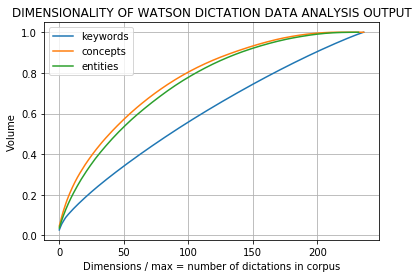

In [2]:
## INSTANTIATE THE WatsonDocumentArchetypes OBJECT as 'wda' 
# Split dictations into train/test-set with 5% set aside as test-dictations
# wda_a has no test-dictations, all are included in the corpus.

wda    = WatsonDocumentArchetypes(PATH,NLU,train_test = 0.05)
wda_a  = WatsonDocumentArchetypes(PATH,NLU,train_test = False)


## DIMENSIONALITY OF THE CORPUS
# Establish with Singular Value Decomposition (principal component analysis) :

types = ['keywords','concepts','entities']
svde  = {}
volume = {}
volume_distribution = {}

for typ in types:
    svde[typ]     = Svd(wda.X_matrix(typ))
    volume[typ] = svde[typ].s.sum()
    volume_distribution[typ] = svde[typ].s.cumsum()/volume[typ]
    plt.plot(volume_distribution[typ],label = typ)
plt.title('DIMENSIONALITY OF WATSON DICTATION DATA ANALYSIS OUTPUT')
plt.xlabel('Dimensions / max = number of dictations in corpus')
plt.ylabel('Volume')
plt.legend()
plt.grid()
plt.show()

## COMMENT: CONCEPTS AND ENTITIES OFFER A GREATER REDUCTION OF DIMENSIONALITY = THE MODELS FIT THE DATA BETTER (?)
## ? => WE ARE MEASURING THE WATSON OUTPUT ONLY. WE DON'T KNOW WHAT IS GOING ON INSIDE WATSON. 

## CONCLUSIONS: 
## DICTATION WORD/ENTITY/CONCEPTUAL CONTENT IS DIVERSE AND SPREAD OVER MANY DIMENSIONS
## ACCESS TO A LARGER CORPUS SHOULD BE VERY GOOD!


### COMMENT: 

CONCEPTS AND ENTITIES OFFER A GREATER REDUCTION OF DIMENSIONALITY = THE MODELS FIT THE DATA BETTER (?)

? => WE ARE MEASURING THE WATSON OUTPUT ONLY. WE DON'T KNOW WHAT IS GOING ON INSIDE WATSON. 

## DIMENSIONALITY - CONCLUSIONS: 
- iN OUR EXISTING CORPUS, THE DICTATION WORD/ENTITY/CONCEPTUAL CONTENT IS DIVERSE AND SPREADS ACROSS MANY DIMENSIONS
- ACCESS TO A LARGER CORPUS SHOULD BE VERY GOOD!

# EXPLORING ARCHETYPES

When exploring the dimensionality of the problem we used SVD - the 'singular value decomposition' of a matrix of data. Now we move on to Archetypal analysis, a type of 'soft clustering'. 

The relationship between SVD and Archetypes/Cluster representations is not unlike the relation between waves and particles, where SVD is more like an overlay of multiple waves, like jpeg uses the fourier/cosine transform to decompose pictures, while Archetypes/Clusters are more like representing the picture as a sum of objects. The dimensionality distribution in SVD is not unlike the frequency distribution in a jpeg, although much less restricted. Fourier/Cosine transform has its basis functions predefined and has to stick to its delocalized functions, while SVD is more flexible in its choice of basis functions. The don't have to be delocalized, even if they often are. In fact, the clustering/Archetypal analysis trades information quality in return for intuitive interpretability. It is easier to understand a sum of objects than an overlay of waves. The key difference is that waves have phase, they have both negative and positive amplitude. Objects, on the other hand, never have negative presence - the presence of objects always add up, they can't cancel each other out like waves do. This explains the name of the method we use for computing the Archetypes/Clusters: "Non-Negative Matrix Factorization" (NMF). SVD factorizes a matrix into orthogonal components that can have either negative of positive matrix elements. NMF requires that all matrix elements are positive. NMF does, however, still allow delocalization. In straightforward clustering models, an element belongs to one or the other cluster. NMF is an example of "soft clustering" where an element can belong to several clusters, just like a word can belong to several overlapping categories. 

Since NMF has more restrictions than SVD, we assume that SVD is a lower limit for the dimensionality reduction that can be achieved through NMF. According to the same line of reasoning, the overlap between two different Archetypes/Soft Clusters can't be smaller than zero. The overlap between two different modes of 'waves' in SVD will always be zero. 

With this in mind we now identify the Archetypes of our corpus of dictations by computing the NMF-clusters. 

Here below we choose to partition our corpus into six archetypes. 

# BUILDING THE ARCHETYPES


In the plots below the different archetypes are shown and compared. Each plot is organized so that one (key) archetype is plotted in order from its largest variable and downwards. The other archetypes' values for the same components are shown for comparison. 

The list is truncated where the key archetype's component values go below 10% of the strongest component. 

## 1. FROM ENTITIES

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



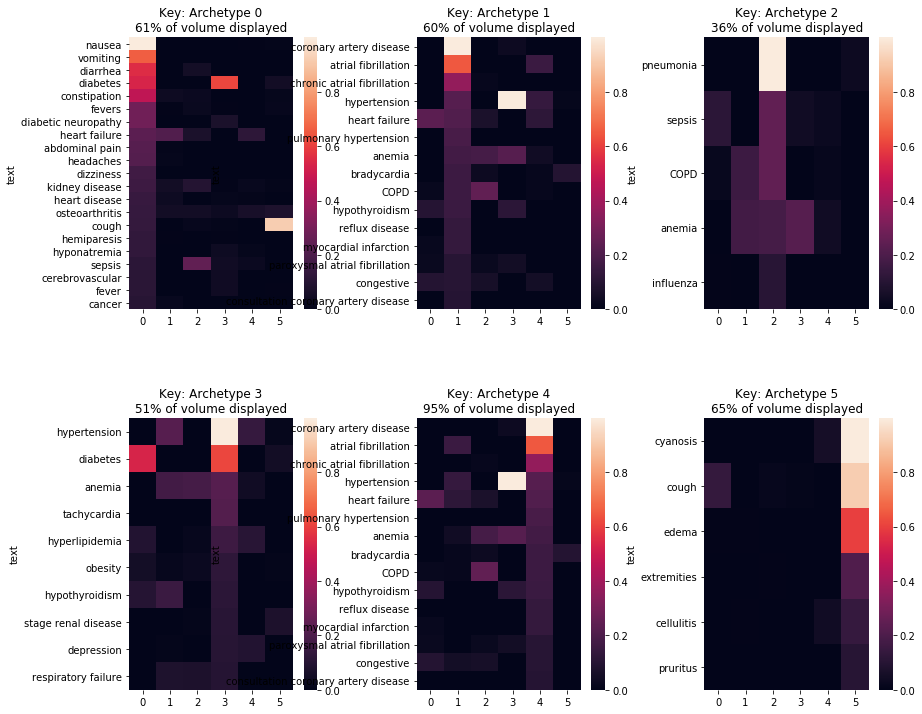

In [3]:
typ = 'entities'
fig = plt.figure(figsize=(14, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_archs   = 6
threshold = 0.1
for i in range(n_archs):
    tot = wda.archetypes(typ = typ,n_archs=n_archs).f.T.apply(scale)[i].sum()
    f =   wda.display_archetype(typ = typ,n_archs=n_archs, arch_nr=i, threshold = threshold, norm = scale)
    ax = fig.add_subplot(2, 3, i+1)
    ax.title.set_text('Key: Archetype '+str(i)+'\n'+str(int(100*f[i].sum()/tot))+'% of volume displayed')
    sns.heatmap(f)
fig.show()

### CROSS-COMPARISON
We define similarity as the cosine distance.

All entity-archetypes are very different from each other, apart from archetypes 0 and 2, they have 35% similarity.  

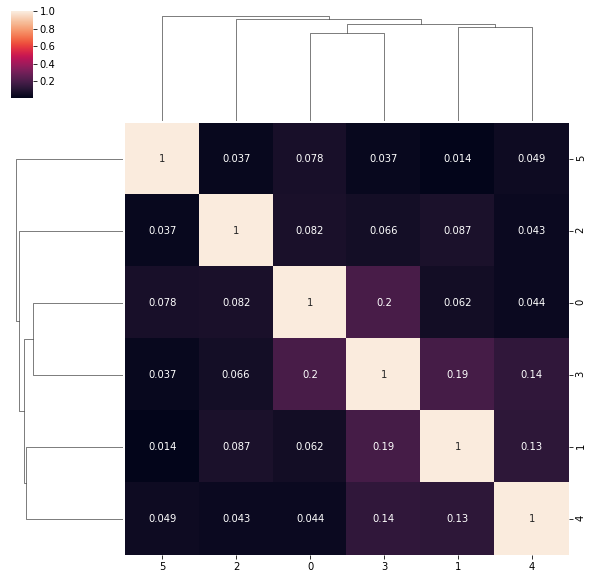

In [4]:
f = wda.archetypes(typ = typ,n_archs=n_archs).f.T.apply(norm_dot)
sns.clustermap(f.T @ f,annot=True)

## 2. FROM CONCEPTS

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



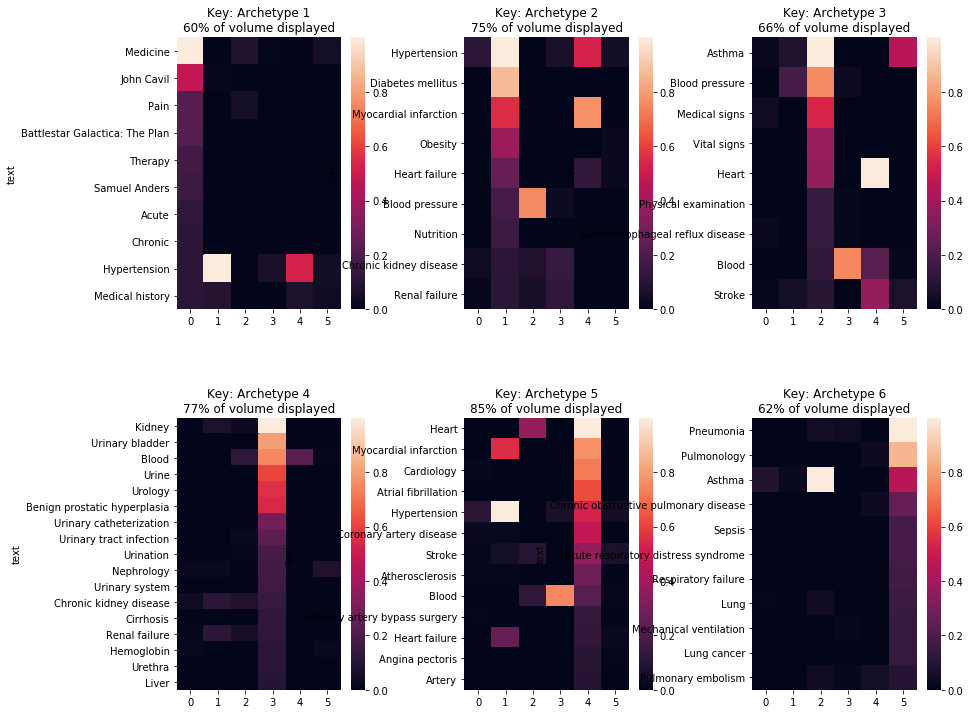

In [5]:
typ = 'concepts'
fig = plt.figure(figsize=(14, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_archs   = 6
threshold = 0.1
for i in range(n_archs):
    tot = wda.archetypes(typ = typ,n_archs=n_archs).f.T.apply(scale)[i].sum()
    f =   wda.display_archetype(typ = typ,n_archs=n_archs, arch_nr=i, threshold = threshold, norm = scale)
    ax = fig.add_subplot(2, 3, i+1)
    ax.title.set_text('Key: Archetype '+str(i+1)+'\n'+str(int(100*f[i].sum()/tot))+'% of volume displayed')
    sns.heatmap(f)
fig.show()

### CROSS-COMPARISON
We define similarity as the cosine distance.

The concept-archetypes are also different from each other, the similarities are more evenly distributed than for entity-archetypes.

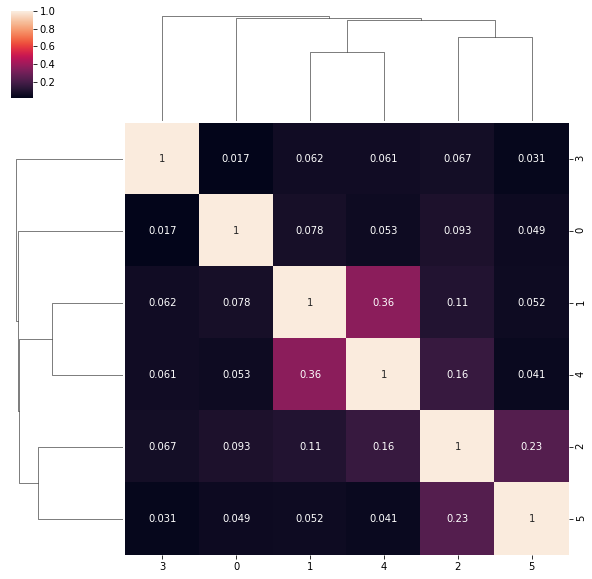

In [6]:
f = wda.archetypes(typ = typ,n_archs=n_archs).f.T.apply(norm_dot)
sns.clustermap(f.T @ f,annot=True)

## 3. FROM KEYWORDS


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



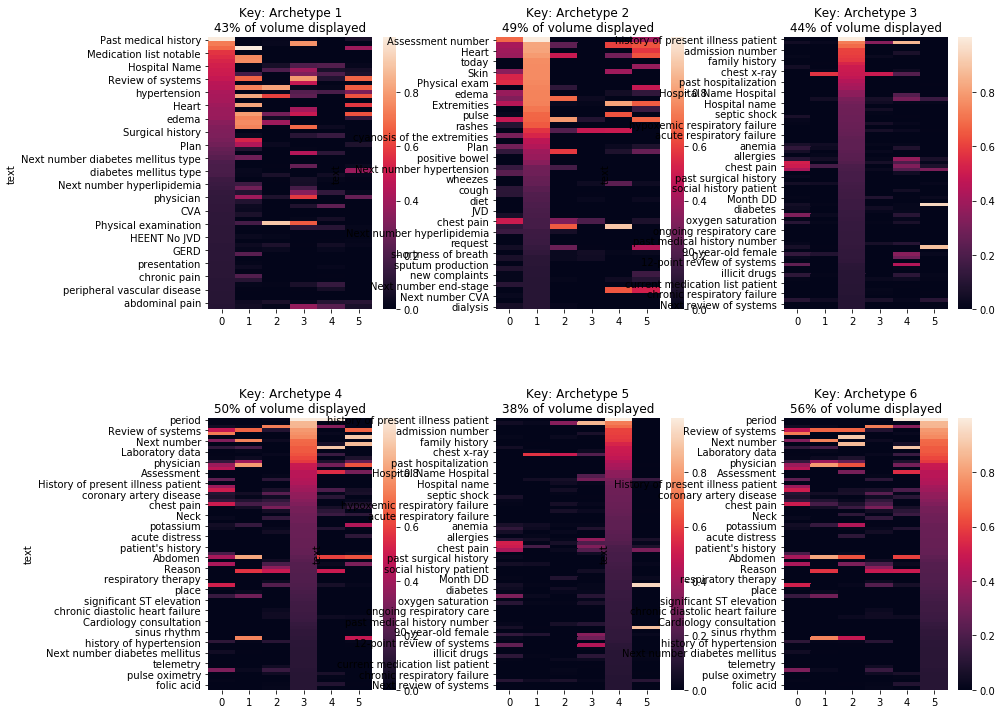

In [7]:
typ = 'keywords'
fig = plt.figure(figsize=(14, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_archs   = 6
threshold = 0.1
for i in range(n_archs):
    tot = wda.archetypes(typ = typ,n_archs=n_archs).f.T.apply(scale)[i].sum()
    f =   wda.display_archetype(typ = typ,n_archs=n_archs, arch_nr=i, threshold = threshold, norm = scale)
    ax = fig.add_subplot(2, 3, i+1)
    ax.title.set_text('Key: Archetype '+str(i+1)+'\n'+str(int(100*f[i].sum()/tot))+'% of volume displayed')
    sns.heatmap(f)
fig.show()

### CROSS-COMPARISON
We define similarity as the cosine distance.

The keyword-archetypes are significantly more overlapping than entity-archetypes and concept-archetypes.

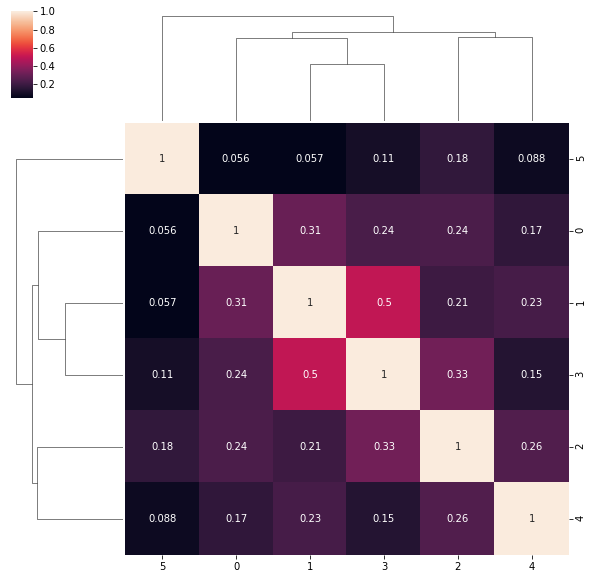

In [8]:
f = wda.archetypes(typ = typ,n_archs=n_archs).f.T.apply(norm_dot)
sns.clustermap(f.T @ f,annot=True)

# USING THE ARCHETYPES AS A COORDINATE SYSTEM FOR DOCUMENTS

We apply hierarchical clustering (dendrograms) to organize the dictations so that the clustering ones are put next to each other. We see that they are quite distinct. 

The columns represent the six archetypes, he rows are the dictations. 

The dictations are normalized so that the sum of coefficients over the archetypes sum up to exactly one for each dictation. A row with a completely white segment will therefore be completely black otherwise, indicating that 100% of he dictation belongs to the 'white' archetype. 

## ENTITY-ARCHETYPES

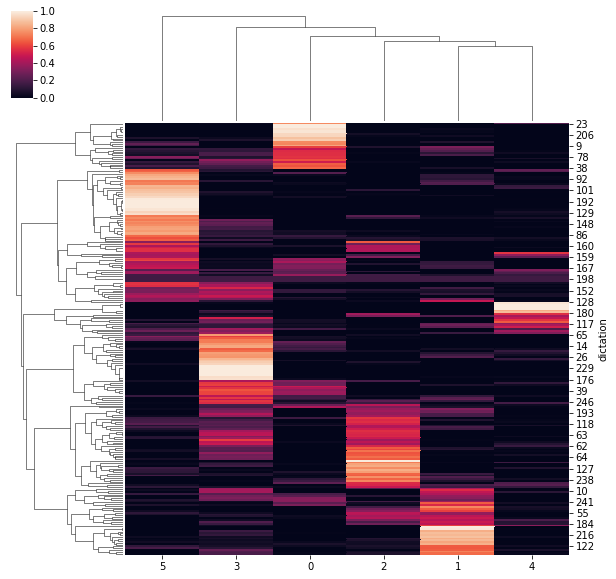

In [9]:
## ARCHETYPES based on ENTITIES in corpus texts
typ = 'entities'
n_archs = 6
f = wda.archetypes(typ=typ,n_archs=n_archs).o.applymap(lambda X: X+0.00000000000000001).T
sns.clustermap(f.apply(norm_sum).T)

### SIMILARITY MATRIX: DOCUMENT CLUSTERS

The documents in the (cosine) similarity matrix have been sored by hierarchical clustering (dendrograms) so that the documents with the greatest similarity in the six-dimensional archetype echosystem are placed next to each other, forming clusters.  

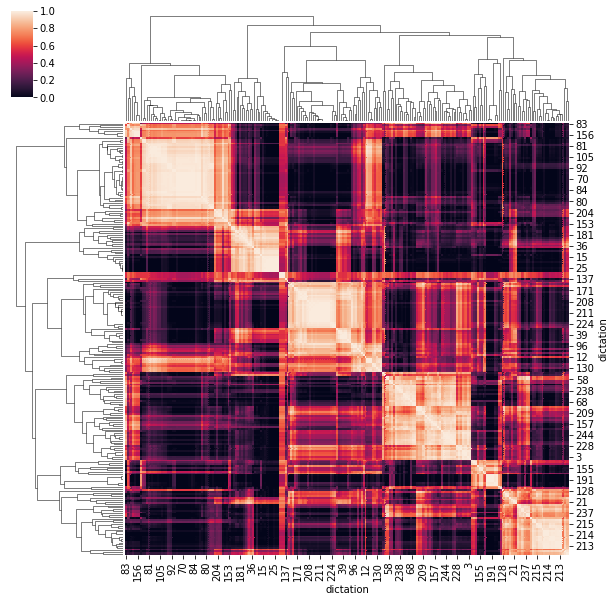

In [10]:
g = f.apply(norm_dot)
sns.clustermap(g.T @ g)

## CONCEPT - ARCHETYPES

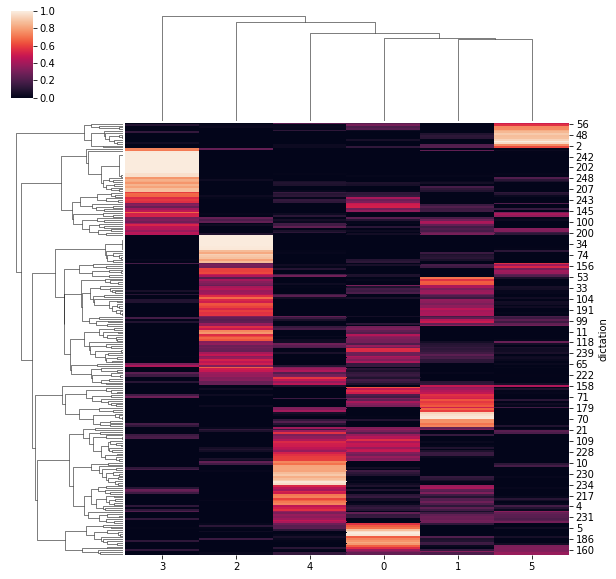

In [11]:
## ARCHETYPES based on CONCEPTS in corpus texts
typ = 'concepts'
n_archs = 6
f = wda.archetypes(typ=typ,n_archs=n_archs).o.applymap(lambda X: X+0.00000000000000001).T
sns.clustermap(f.apply(norm_sum).T)

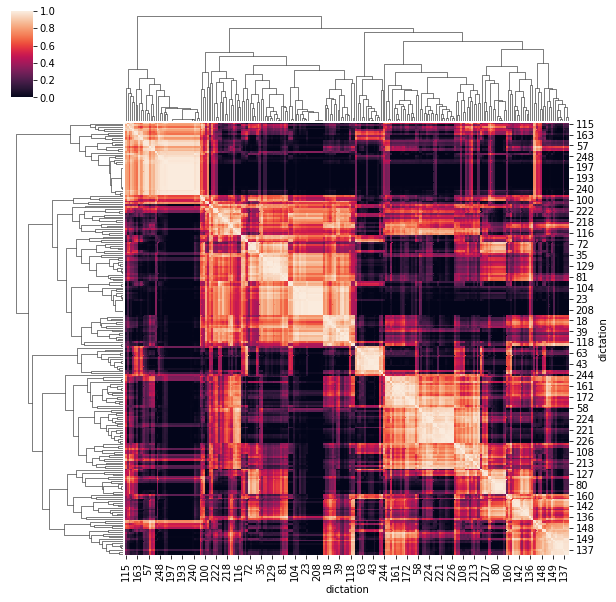

In [12]:
g = f.apply(norm_dot)
sns.clustermap(g.T @ g)

## KEYWORD-ARCHETYPES 

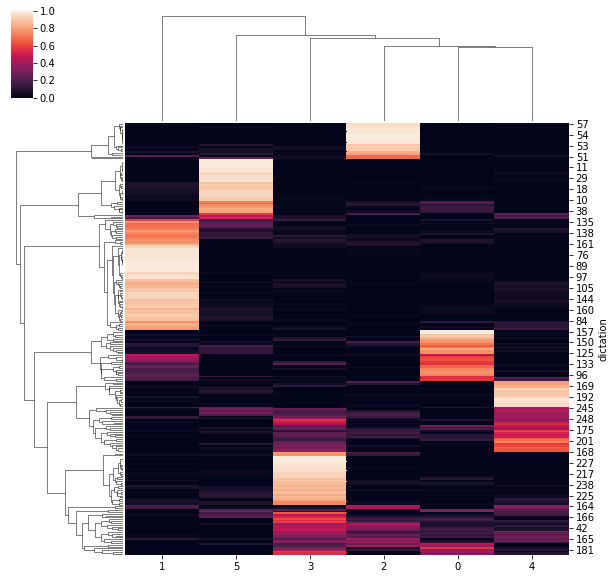

In [13]:
## ARCHETYPES based on KEYWORDS in corpus texts
typ = 'keywords'
n_archs = 6
f = wda.archetypes(typ=typ,n_archs=n_archs).o.applymap(lambda X: X+0.00000000000000001).T
sns.clustermap(f.apply(norm_sum).T)

### SIMILARITY MATRIX: DOCUMENT CLUSTERS

The documents in the (cosine) similarity matrix have been sored by hierarchical clustering (dendrograms) so that the documents with the greatest similarity in the six-dimensional archetype echosystem are placed next to each other, forming clusters. 

While keyword-archetypes have the most overlap, their document clusters seems to be the most distinctly separated. **???? WHY ???**

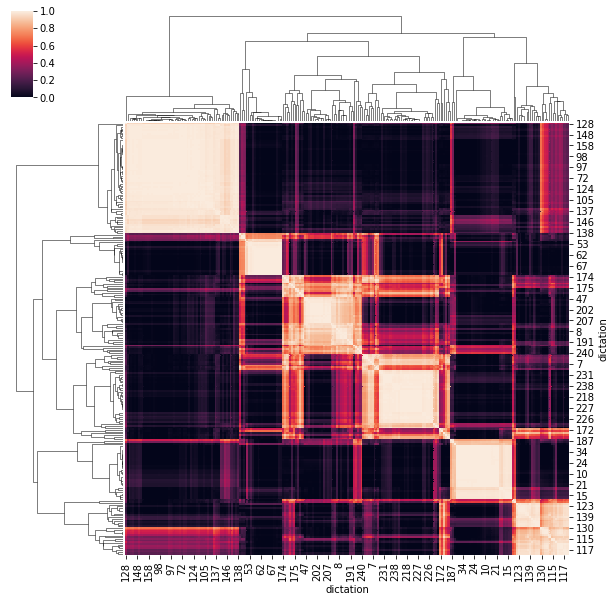

In [14]:
g = f.apply(norm_dot)
sns.clustermap(g.T @ g)

# ANALYZING NEW DOCUMENTS

**SCENARIO**: 
- 1 A physician dictates notes after examining a patient. 
- 2 The dictation is automatically transcribed. 
- 3 The dictation (transcript) is analyzed by Watson NLU, returning entities/concepts/keywords as shown above.
- 4 The analysis is mapped onto the archetypes shown above and returned to the physician. 

Note that we do not include the new dictation in the corpus.

Here we will go through steps 3-4, assuming that 1-2 have already been performed. 

## 2. The New Transcript

We emulate a new transcript by picking one from our test set. Not included in the corpus. 



In [15]:
test = {}

In [107]:
## We emulate a new transcript by picking one from our test set. Not included in the corpus. 
test['names'] = wda.names_test
test['names']

array(['147', '141', '173', '16', '131', '44', '91', '195', '189', '61',
       '73', '22'], dtype='<U3')

In [108]:
## Sample from test-set

test['dictation'] = {}

for name in test['names']:
    test['dictation'][name] =  wda.dictation_df.loc[name]
    

In [94]:
    
test['dictation'][test['names'][3]]

'Medical status the patient was seen and examined on rounds in the patient’s room. She complains of she continues to make progress in all therapeutic areas. She is tolerating three hour physical therapy and occupational therapy. Review of systems she complains of left hip pain. She voices no other new complaints. Remainder of the 14-point review of systems is essentially negative. On exam pleasant female in no acute distress. Vital signs are stable. Blood pressure 130/63, temperature 98.4, heart rate 92. HEENT extraocular motions intact. Mucous membranes moist without lesions. Neck supple without lymphadenopathy. Lungs clear to auscultation without rhonchi crepitus nor wheezing. Heart regular rate and rhythm without murmurs. No extra sounds. Abdomen soft, nontender, no organomegaly. Extremities extremities with trace edema in the lower extremities with venostasis changes noted. Spine minimal lumbosacral paraspinal tenderness. Neurologic giveway weakness noted at the hips and shoulders 

## 3. RUN WATSON NLU ON TEST DICTATION

In [ ]:
## Call Watson API
def watson_nlu(text, 
               typ_list = ['entities','concepts','keywords']):
    module = wda.nlu_model.analyze(text = text, features=NLU['features'])
    result = {}
    for typ in typ_list:
         result[typ] = pd.DataFrame(module.result[typ])
    return result


## save fresh Watson API results
test['watson'] = {}
for name in test['names']:
    test['watson'][name] = watson_nlu(test['dictation'][name])
    

In [113]:
## Example of result

nn = test['names'][0]
test['watson'][nn]['concepts']

,dbpedia_resource,relevance,text
0,http://dbpedia.org/resource/Diabetes_mellitus,0.951003,Diabetes mellitus
1,http://dbpedia.org/resource/Heart,0.892360,Heart
2,http://dbpedia.org/resource/Hypertension,0.834717,Hypertension
3,http://dbpedia.org/resource/Medicine,0.785882,Medicine
4,http://dbpedia.org/resource/Stroke,0.758052,Stroke
5,http://dbpedia.org/resource/Blood_pressure,0.743806,Blood pressure
6,http://dbpedia.org/resource/Cystic_fibrosis,0.715214,Cystic fibrosis
7,http://dbpedia.org/resource/Acupuncture,0.711229,Acupuncture


In [120]:
## CONFIRMED RESULT! 
## The freshly calculated result above is CONFIRMED by being identical to the one previously calculated (wda sends the test-set 
## to Watson, but it does not inlcude them in the calculation of archetypes. 

wda.watson_nlu[nn]['concepts']

,dbpedia_resource,relevance,text
0,http://dbpedia.org/resource/Diabetes_mellitus,0.951003,Diabetes mellitus
1,http://dbpedia.org/resource/Heart,0.892360,Heart
2,http://dbpedia.org/resource/Hypertension,0.834717,Hypertension
3,http://dbpedia.org/resource/Medicine,0.785882,Medicine
4,http://dbpedia.org/resource/Stroke,0.758052,Stroke
5,http://dbpedia.org/resource/Blood_pressure,0.743806,Blood pressure
6,http://dbpedia.org/resource/Cystic_fibrosis,0.715214,Cystic fibrosis
7,http://dbpedia.org/resource/Acupuncture,0.711229,Acupuncture


In [135]:
## Construct the 'concepts'-word vector

cowv = test['watson'][nn]['concepts'].set_index('text')[['relevance']]
cowv

,relevance
text,
Diabetes mellitus,0.951003
Heart,0.892360
Hypertension,0.834717
Medicine,0.785882
Stroke,0.758052
Blood pressure,0.743806
Cystic fibrosis,0.715214
Acupuncture,0.711229


In [138]:
## Normalize the word vector - dot-product / cos-similarity
cowv  = cowv.apply(norm_dot)
cowv

,relevance
text,
Diabetes mellitus,0.418642
Heart,0.392826
Hypertension,0.367451
Medicine,0.345954
Stroke,0.333703
Blood pressure,0.327431
Cystic fibrosis,0.314845
Acupuncture,0.313091


In [145]:
## Dot-Normalize the archetypes - preparing for mapping cowv

arch_set = wda.archetypes(typ='concepts',n_archs = 6).f.copy()
arch_set = arch_set.T.apply(norm_dot)
arch_set.head(10)

,0,1,2,3,4,5
text,,,,,,
2,0.002958,0.000000,0.000000,0.000000,0.000997,0.000000
Abdomen,0.000000,0.000000,0.000096,0.000112,0.000000,0.000047
Abdominal pain,0.004415,0.008165,0.000000,0.015604,0.000000,0.000271
Abnormal psychology,0.004921,0.000000,0.000000,0.000000,0.000000,0.000000
Acinetobacter,0.000000,0.000843,0.000000,0.000000,0.000000,0.031277
Acromion,0.000010,0.000000,0.000000,0.000000,0.000030,0.000016
Acupuncture,0.003692,0.000000,0.000000,0.000000,0.006355,0.000000
Acute,0.101440,0.000000,0.000000,0.000000,0.000000,0.000000
Acute respiratory distress syndrome,0.000000,0.000000,0.000000,0.000000,0.000000,0.118956


In [263]:
## Map!

nn_map = (cowv.T @ arch_set.loc[cowv.index])
nn_map

,0,1,2,3,4,5
relevance,0.324289,0.521714,0.304836,0.023477,0.390649,0.043066


In [264]:
nn_map = nn_map/ nn_map.values.sum() # Normalize sum to 1 (due to non-orthogonal basis set)
nn_map

,0,1,2,3,4,5
relevance,0.201668,0.324443,0.189571,0.0146,0.242936,0.026782


In [191]:
arch_set2 = wda_a.archetypes(typ='concepts',n_archs =6).f.T.apply(norm_dot)

In [192]:
arch_set2.shape

(361, 6)

In [193]:
arch_set22 = arch_set2.loc[arch_set.index].apply(norm_dot)

In [234]:
## We see that the Archetypes of the full set and the trainingset, respectively, are nearly the same - 
## because the cos-similarity > 0.99 for each archetype. 
aaa = arch_set22.T @ arch_set
aaa

,0,1,2,3,4,5
0,0.077906,0.999170,0.097708,0.064422,0.354563,0.046876
1,0.016394,0.055265,0.067957,0.997076,0.062132,0.028547
2,0.998674,0.067272,0.086536,0.014656,0.046133,0.043077
3,0.041187,0.061104,0.164572,0.027475,0.042533,0.990678
4,0.097688,0.110816,0.995333,0.070613,0.157761,0.272568
5,0.056626,0.366289,0.158609,0.060253,0.999766,0.042221


In [224]:
## NOTE: the archetypes are not in the same order
#@ In order to align them, we must shift the columns of the full-set archetypes so that the max-similarities with the 
## training-set archetypes are on the diagonal
## We do this by identifyin g the positions of the max similarities:
reorder = aaa.T.idxmax().to_dict()
reorder 

{0: 1, 1: 3, 2: 0, 3: 5, 4: 2, 5: 4}

In [235]:
ccc = arch_set.copy()
bbb = arch_set22.copy()
bbb.columns = list(reorder.values())
bbbb= bbb.T.sort_index()

In [242]:
## REORDERING CONFIRMED!
## Now bbbb (full-set) and ccc (training set) archetypes are aligned - the max similarities are on the diagonal 
## We therefore now that 'reorder' is correct.
bbbb @ ccc

,0,1,2,3,4,5
0,0.998674,0.067272,0.086536,0.014656,0.046133,0.043077
1,0.077906,0.999170,0.097708,0.064422,0.354563,0.046876
2,0.097688,0.110816,0.995333,0.070613,0.157761,0.272568
3,0.016394,0.055265,0.067957,0.997076,0.062132,0.028547
4,0.056626,0.366289,0.158609,0.060253,0.999766,0.042221
5,0.041187,0.061104,0.164572,0.027475,0.042533,0.990678


In [266]:
## We now look at how our test-vector is mapped onto the archetypes when it is a part of the corpus (in the full-set)

nn_comp = wda_a.archetypes(typ='concepts',n_archs = 6).o.apply(norm_sum,axis=1).loc[nn]
nn_comp

0    0.312584
1    0.000000
2    0.306001
3    0.000000
4    0.238014
5    0.143400
Name: 147, dtype: float64

In [268]:
## nn_comp sums up to 1 - is normalized. 

nn_comp.sum()

0.9999999999999999

In [282]:
## Now we reorder the mapping of the test-word-vector so that it is aligned with nn_comp

nn_map[[1, 3, 0, 5, 2, 4]]

,1,3,0,5,2,4
relevance,0.324443,0.0146,0.201668,0.026782,0.189571,0.242936


In [283]:
## ... and compare to the distribution across archetypes when it is part of the corpus
pd.DataFrame(nn_comp).T

,0,1,2,3,4,5
147,0.312584,0.0,0.306001,0.0,0.238014,0.1434
